In this notebook, we will implement a Convoulutional Neural Network (CNN) using pytorch for CIFAR-10 Classification.

Expectations: Please provide solutions to the questions in the cells at the end of the notebook.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

We will be using [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) datasets which is sub-dataset of CIFAR-100 Dataset. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. <br>

Following are the classes in the dataset along with some random samples.

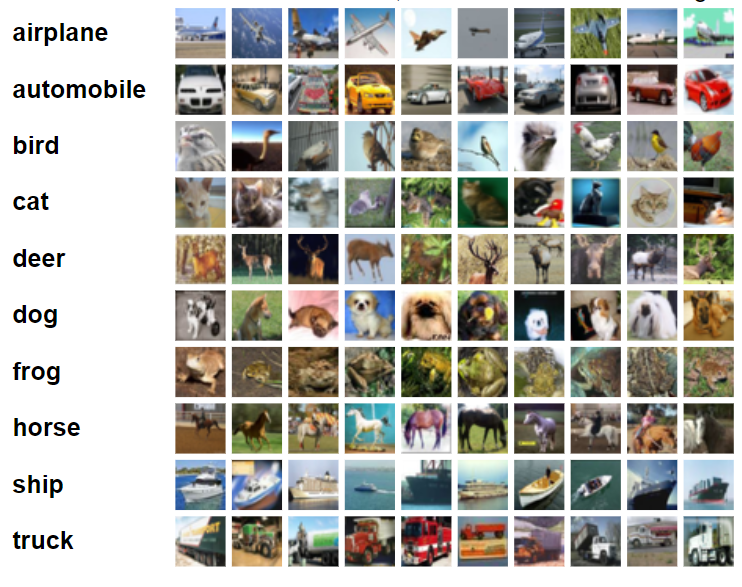

We will use pytorch datasets to fetch the CIFAR-10 dataset as it provides a handy way to get and use the dataset. More information about pytorch datasets [here](https://pytorch.org/vision/stable/datasets.html).

In [ ]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data

train_dataset = CIFAR10(root='./datasets', train=True, download=True, transform = transforms.ToTensor())
test_dataset = CIFAR10(root='./datasets', train=False, download=True, transform = transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size = batch_sz)
test_loader = DataLoader(test_dataset, batch_size = batch_sz)

Files already downloaded and verified
Files already downloaded and verified


## Transfer Learning

Transfer learning means taking the relevant parts of a pre-trained machine learning model and applying it to a new but similar problem. Transfer learning brings a range of benefits to the development process of machine learning models. The main benefits of transfer learning include the saving of resources and improved efficiency when training new models. It can also help with training models when only unlabelled datasets are available, as the bulk of the model will be pre-trained.

![Transfer Learning](https://topb0ts.wpenginepowered.com/wp-content/uploads/2019/12/cover_transfer_learning_1600px_web.jpg) [Source](https://www.topbots.com/transfer-learning-in-nlp/)

## Best Training Result from internet:

*   Two-Layer-Neural-Network:
  *   The final accuracy of the model is 0.554
  * https://github.com/zhangjh915/Two-Layer-Neural-Network


* CNN:
  * CIFAR-10 Dataset CNN Model achieving 85.97% accuracy with regularization and data augmentation.


* Resnet18:
  * 90% accuracy in under 2.5 minutes (intermediate) 94% accuracy in under 5 minutes (hard)



* Random Guess %: 10% (1/10 classes)

## My Result:

\\

*   NN Accuracy: 41.48% (ReLU & softmax, without Data Augementation, 100 neurons, SDG optim)
*   CNN Accuracy: 77.33% (20% DropOut, Batch Normalization, ReLU, kernel_size=3,  with Data Augementation, 100 neurons, Adam optim)
* ResNet18 Accuracy: 86.42% / 93.69% for Validation (Unfreeze all layer, with Data Augementation, 13 epoches)

\\
*Other: Validation Loss is often lower than Training Loss during training, maybe the reasons are regularization (Drop off layer etc...) or validation set may be easier*

*Is it a problem tho?*




---



### Q1: define a 2 layer simple NN for cifar10 classificaiton

In [ ]:
#Similar as before

class NetNN(nn.Module):
  def __init__(self,ni, nh, no):
    super().__init__()
    self.layer1 = nn.Linear(ni, nh) #input
    self.layer2 = nn.Linear(nh, no) #output

  def forward(self,x):
    x = self.layer1(x)
    x = F.relu(x)

    x = self.layer2(x)
    x = torch.softmax(x,dim=1)

    return x

### Q2: Define a CNN with 2 conv layer and 2 linear layers for cifar10 classificaiton

From Internet:

If your images are smaller than 128×128 you may want to consider sticking with strictly 1×1 and 3×3 filters. Also use Adam optimiser with its original values.

In [ ]:
class MyConvNet(nn.Module):
    def __init__(self, ni, nh1, nh2, nh3, no):
        super().__init__()
        self.conv1 = nn.Conv2d(ni, nh1, kernel_size=3, stride=1, padding = 1)
        self.bn1 = nn.BatchNorm2d(nh1)  # Batch normalization layer ->  can adjust all the weights instead of one each time
        self.conv2 = nn.Conv2d(nh1, nh2, kernel_size=3, stride=1, padding = 1)
        self.bn2 = nn.BatchNorm2d(nh2)
        self.linear1 = nn.Linear(8 * 8 * nh2, nh3)
        self.dropout = nn.Dropout(0.2)  # Dropout layer with 20% prob
        self.linear2 = nn.Linear(nh3, no)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1) #Flatten
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

###Spilt Data to Training and Validation Set

In [ ]:
valid_dataset = CIFAR10(root='./datasets', train=True, download=True, transform = transforms.ToTensor())

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

np.random.seed(1212) #seed
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_sz, sampler=train_sampler,pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True)

Files already downloaded and verified


### Q3: Train both networks for 10 epochs and compare their performance

## NN

In [ ]:
device = torch.device("cuda:0")

ni = 32 * 32 * 3  #The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes
nh = 100
no = 10

lr = 0.01
momentum = 0.9
num_epochs = 10

net1 = NetNN(ni, nh, no).to(device)

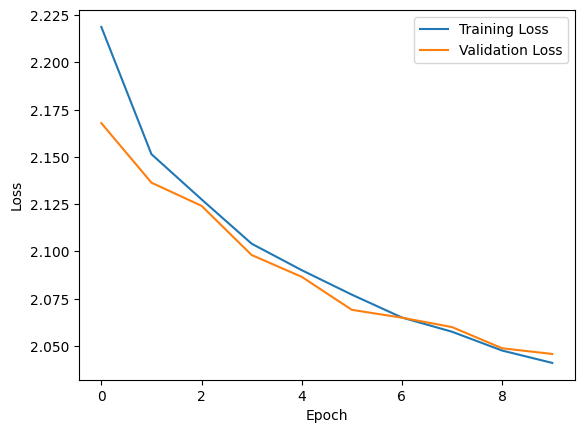

In [ ]:
opt = optim.SGD(net1.parameters(), lr=lr, momentum=momentum)

ls = []
ls_val = []
nums = []

for i in range(num_epochs):
    total_loss = 0

    for batch in train_loader:
        X, y = batch[0].to(device), batch[1].to(device)
        X = X.view(-1, 32 * 32 * 3)  # Flatten image
        logits = net1(X)
        loss = F.cross_entropy(logits, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
        nums.append((loss.item(), X.shape[0]))

    net1.eval()
    total_valid_loss = 0

    with torch.no_grad():
        for batch in valid_loader:
            X, y = batch[0].to(device), batch[1].to(device)
            X = X.view(-1, 32 * 32 * 3)
            logits = net1(X)
            loss = F.cross_entropy(logits, y)
            total_valid_loss += loss.item()

            preds = logits.argmax(dim=1)

    ls_val.append(total_valid_loss / len(valid_loader))
    ls.append(total_loss / len(train_loader))

plt.plot(ls, label='Training Loss')
plt.plot(ls_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## CNN

###Data Augmentation

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

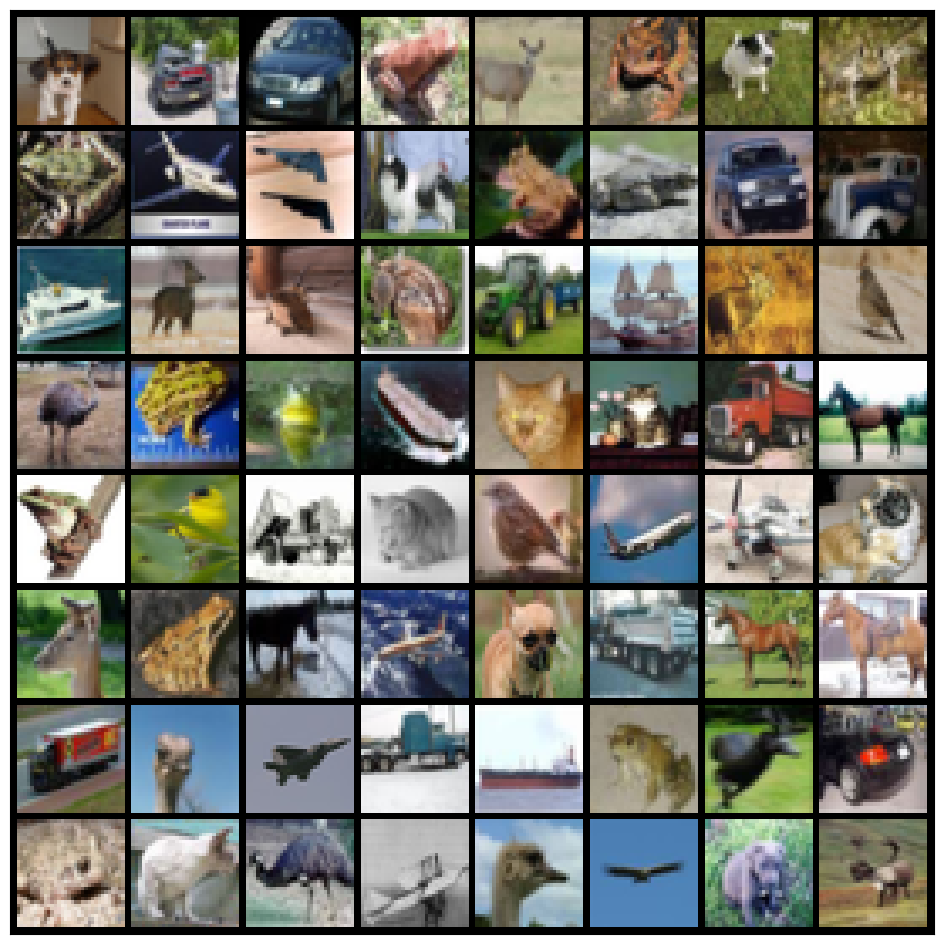

In [ ]:
show_batch(train_loader)

From Internet: pad 4 pixels to 40x40, crop back to 32x32, and randomly flip left and right



In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomGrayscale(p=0.2), #try to decrease the importance of colors
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Imagenet dataset pretrained value
])

train_dataset = CIFAR10(root='./datasets', train=True, download=True, transform = transform_train)
train_loader = DataLoader(train_dataset, batch_size = batch_sz)

Files already downloaded and verified


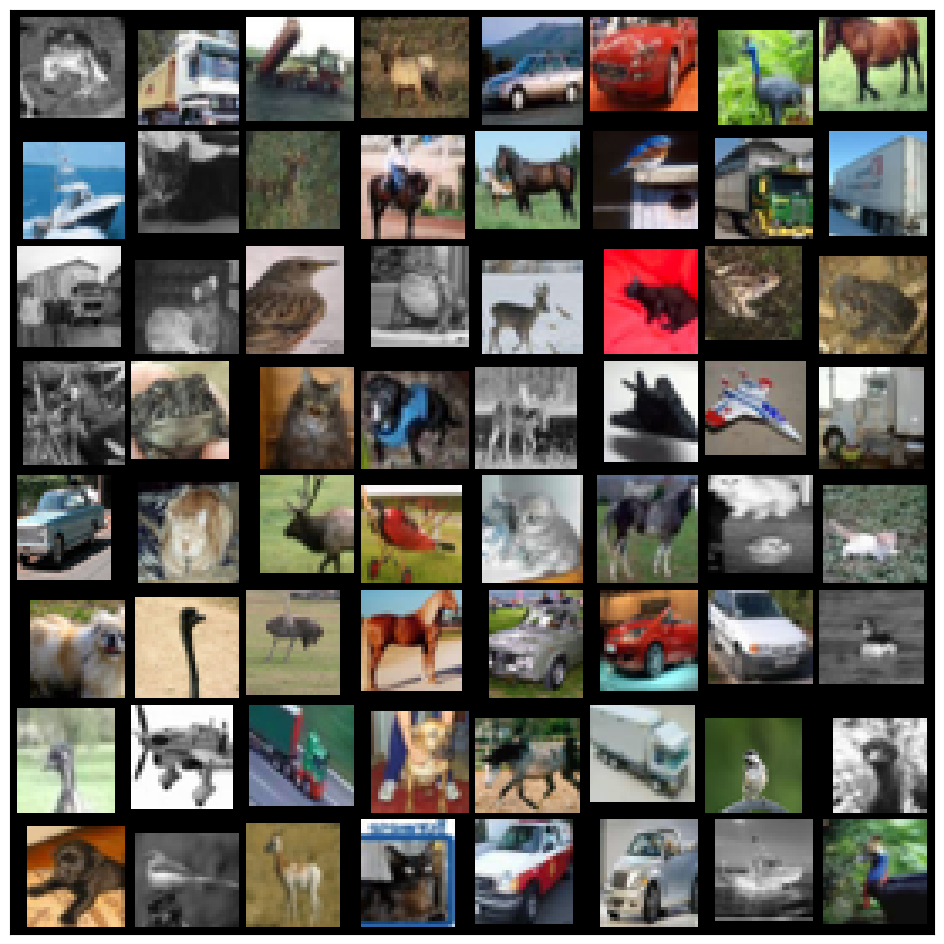

In [ ]:
show_batch(train_loader)

In [ ]:
device = torch.device("cuda:0")

ni = 3  #3 channel
nh1 = 32
nh2 = 64
nh3 = 128
no = 10

net2 = MyConvNet(ni, nh1, nh2, nh3, no)
net2 = net2.to(device)

lr = 0.001
num_epochs = 10

In [ ]:
summary(net2, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 16, 16]          18,496
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Linear-5                  [-1, 128]         524,416
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 545,290
Trainable params: 545,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.75
Params size (MB): 2.08
Estimated Total Size (MB): 2.84
----------------------------------------------------------------


From Internet (to solve my super slow execution time):

Adam is known for its fast convergence and ability to work well on noisy and sparse datasets. It can also handle problems where the optimal solution lies in a wide range of parameter values. Overall, the Adam optimizer is a powerful tool for improving the accuracy and speed of deep learning models.

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.0000e-04.
Iteration 0: Training Loss: 1.498653389456327, Validation Loss: 1.1139984780056462
Adjusting learning rate of group 0 to 8.1000e-04.
Iteration 1: Training Loss: 1.1495002646123051, Validation Loss: 0.8838360586743446
Adjusting learning rate of group 0 to 7.2900e-04.
Iteration 2: Training Loss: 1.0135614638743193, Validation Loss: 0.8521036300689552
Adjusting learning rate of group 0 to 6.5610e-04.
Iteration 3: Training Loss: 0.9413916800942872, Validation Loss: 0.7756183420776561
Adjusting learning rate of group 0 to 5.9049e-04.
Iteration 4: Training Loss: 0.8906087098676531, Validation Loss: 0.7295995768468091
Adjusting learning rate of group 0 to 5.3144e-04.
Iteration 5: Training Loss: 0.8438521501277109, Validation Loss: 0.6879106689790252
Adjusting learning rate of group 0 to 4.7830e-04.
Iteration 6: Training Loss: 0.8140771042584153, Validation Loss: 0.6801173935650261
Adjusting lea

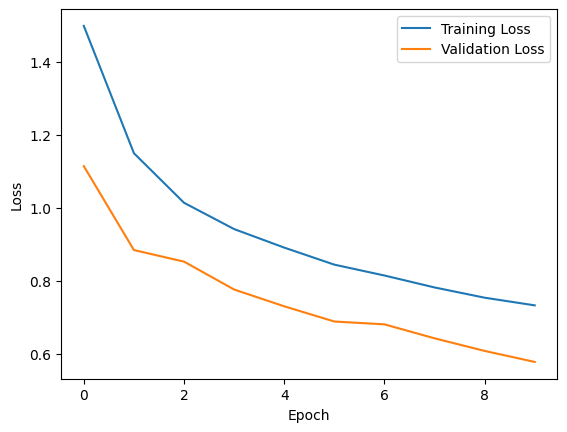

In [ ]:
optimizer = optim.Adam(net2.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)

ls = []
ls_val = []

for i in range(num_epochs):
    loss_total = 0

    for j, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        optimizer.zero_grad()
        data, label = data.to(device), label.to(device)
        logits = net2(data)
        loss = F.cross_entropy(logits, label)
        loss_total += loss.item()
        loss.backward()
        optimizer.step()

    ls.append(loss_total / len(train_loader))
    lr_scheduler.step()

    net2.eval()
    total_valid_loss = 0

    with torch.no_grad():
        for batch in valid_loader:
            data = batch[0]
            label = batch[1]
            data, label = data.to(device), label.to(device)
            logits = net2(data)
            loss = F.cross_entropy(logits, label)
            total_valid_loss += loss.item()

    valid_loss = total_valid_loss / len(valid_loader)
    ls_val.append(valid_loss)

    print(f"Iteration {i}: Training Loss: {loss_total / len(train_loader)}, Validation Loss: {valid_loss}")

plt.plot(ls, label='Training Loss')
plt.plot(ls_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Q4: Compare the accuarcay of both networks on the test set

In [ ]:
import os
from torchvision.utils import save_image

os.makedirs("images", exist_ok=True)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
net1.eval()
acc = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch[0].to(device), batch[1].to(device)
        images = images.view(-1, 32*32*3) #Flatten
        logits = net1(images)
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        acc += (predicted == labels).sum().item()

acc_nn = 100.0 * acc / total


print("NN Accuracy: {:.2f}%".format(acc_nn))

NN Accuracy: 41.48%


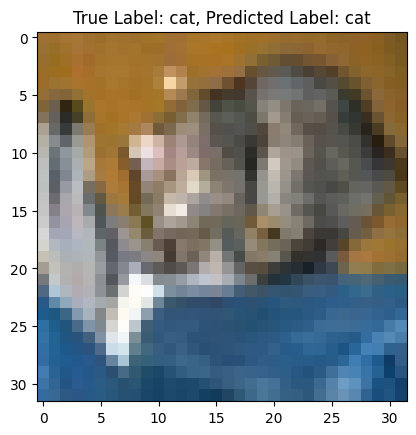

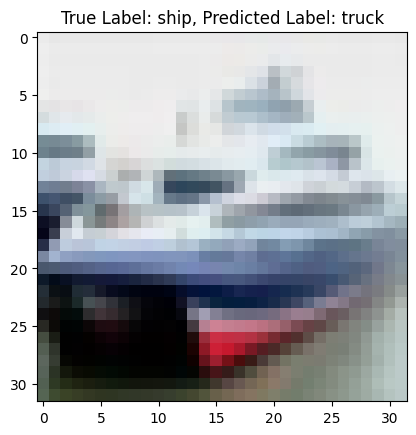

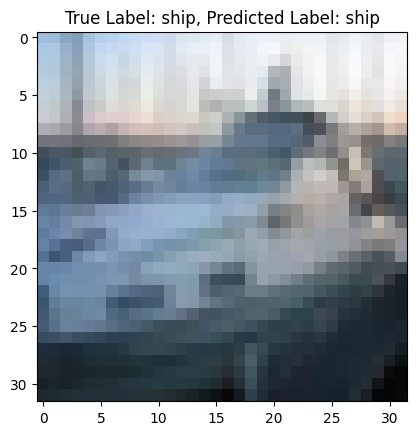

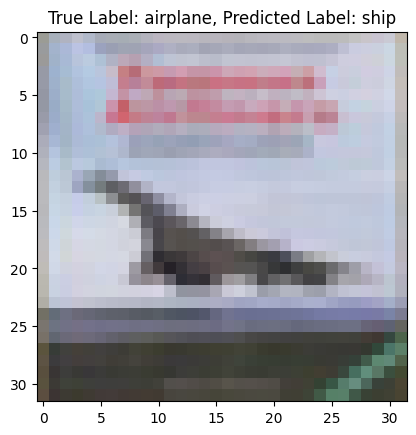

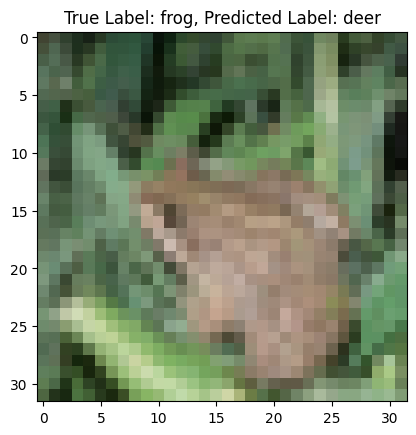

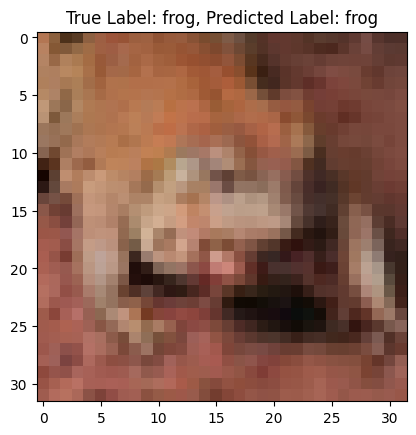

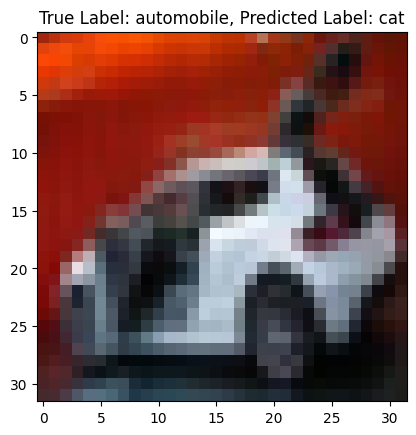

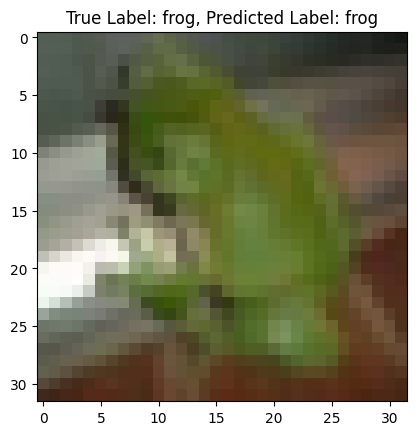

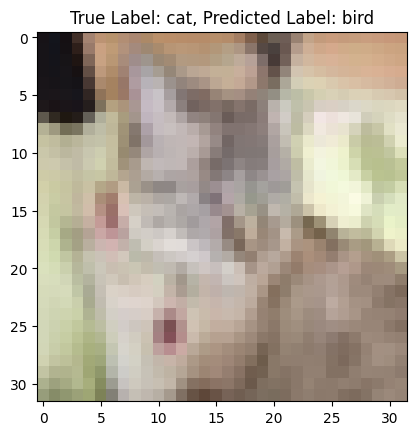

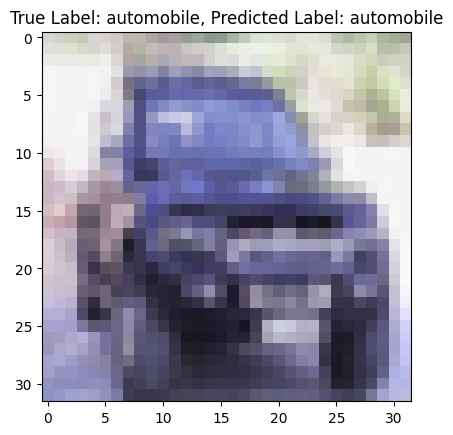

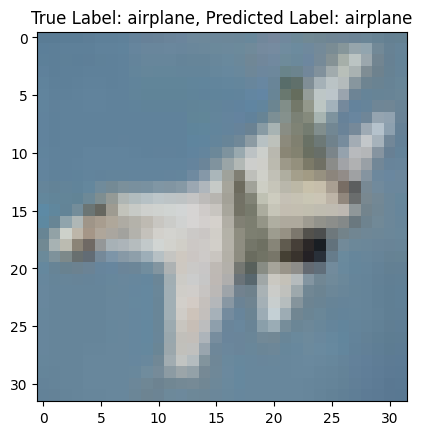

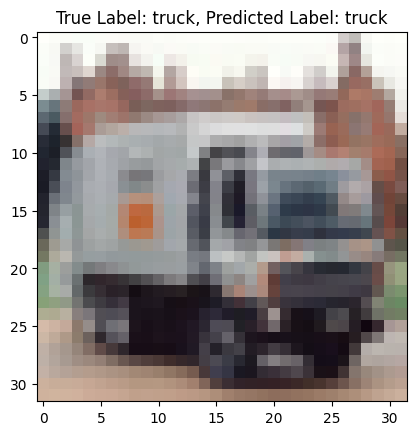

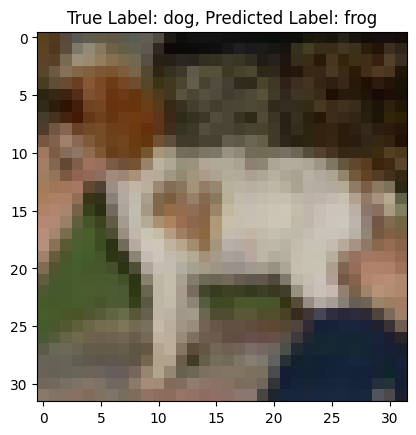

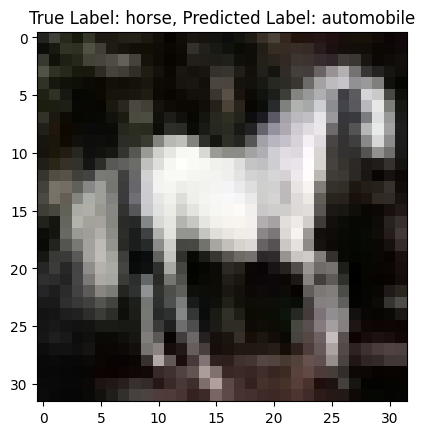

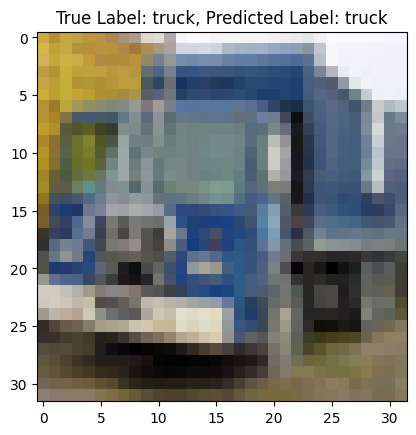

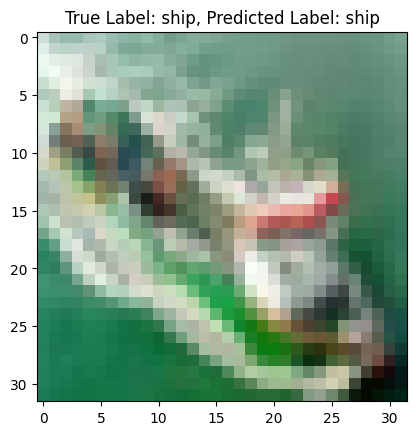

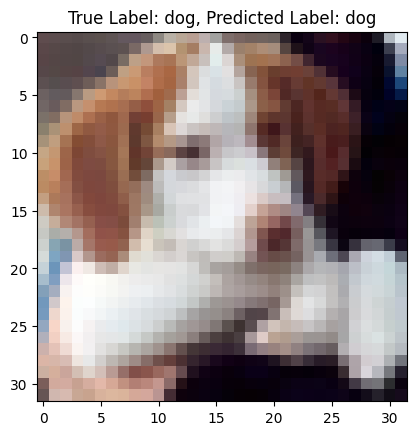

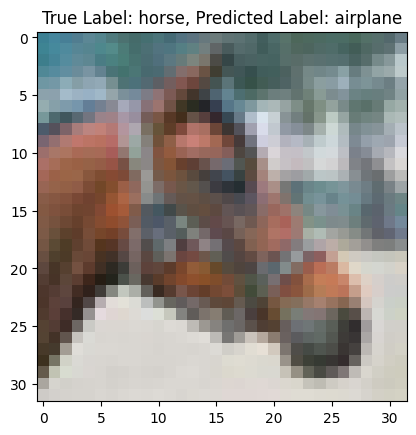

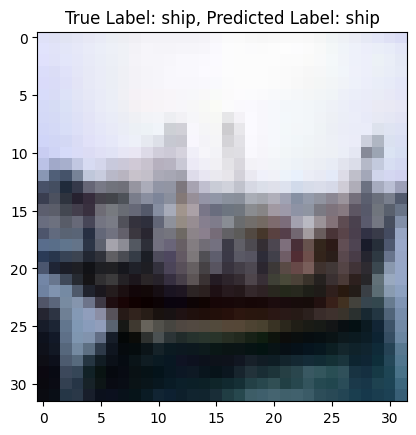

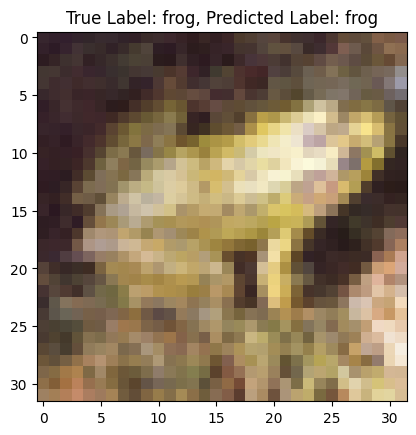

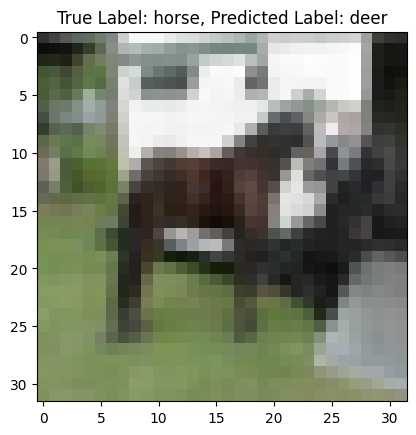

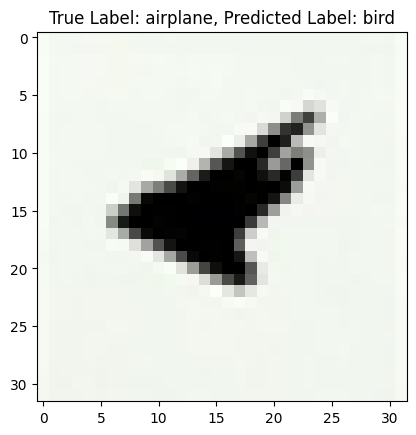

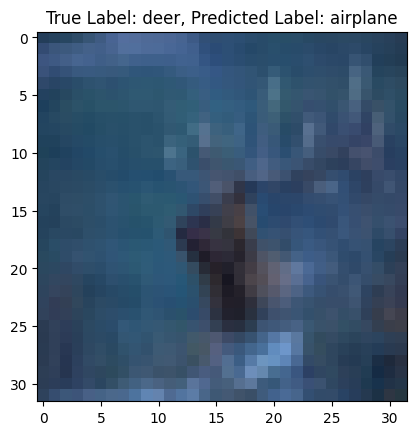

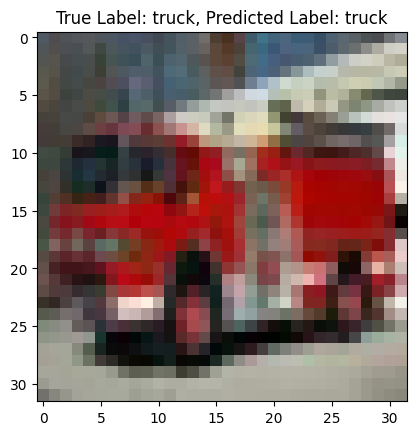

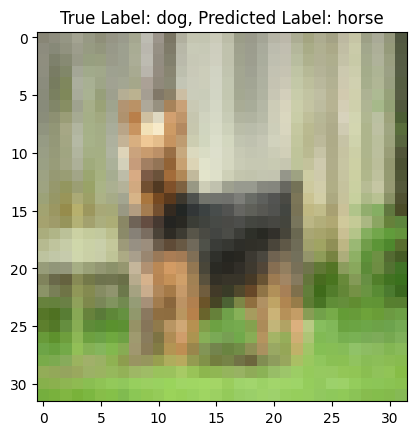

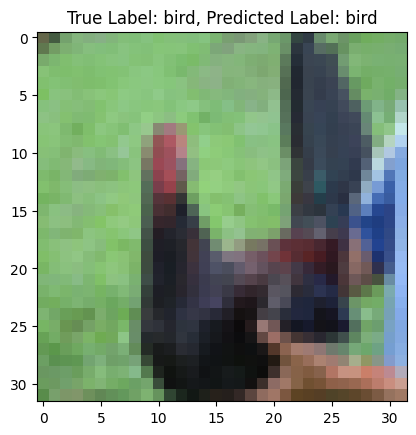

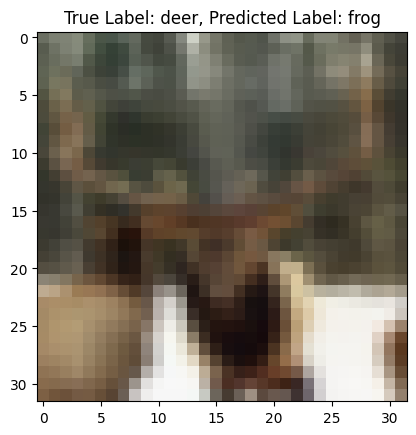

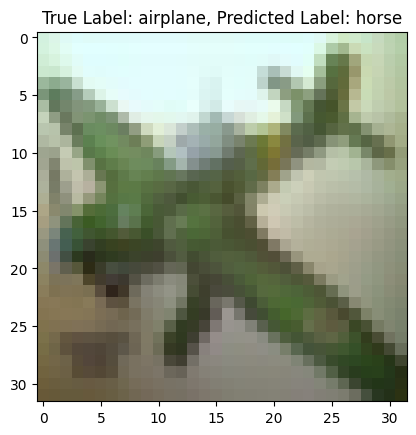

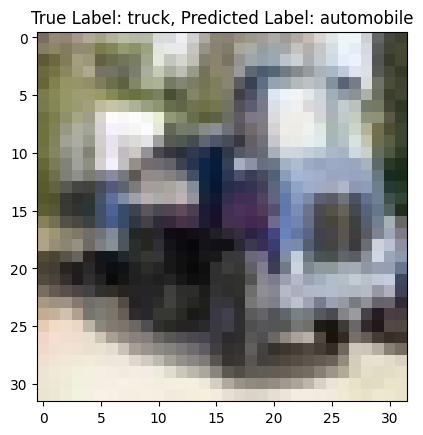

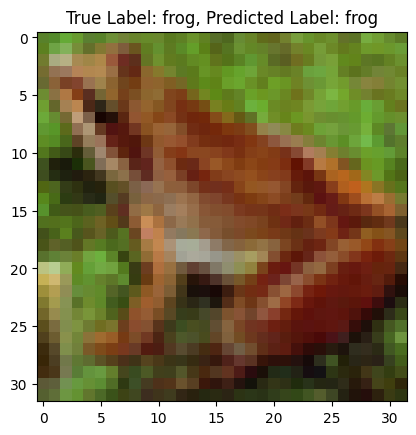

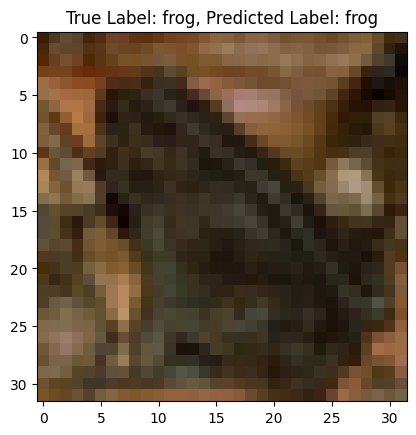

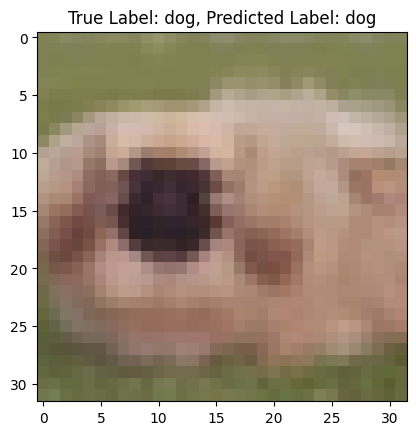

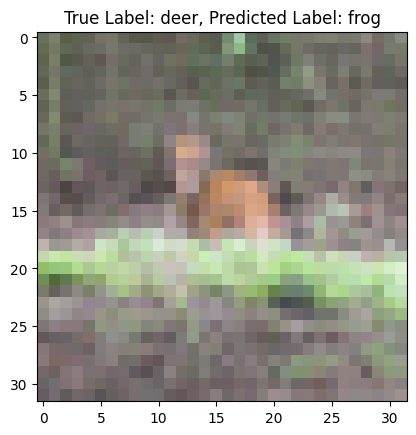

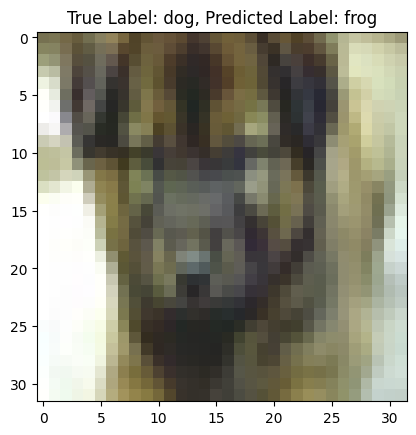

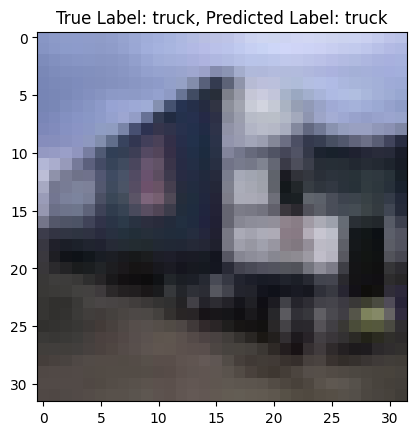

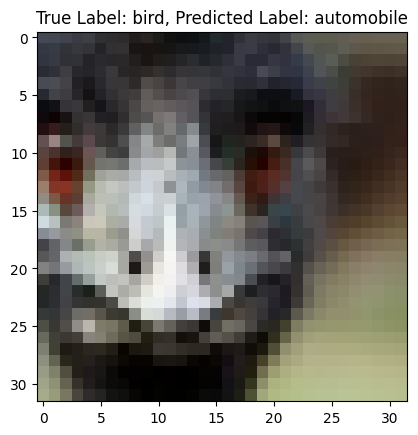

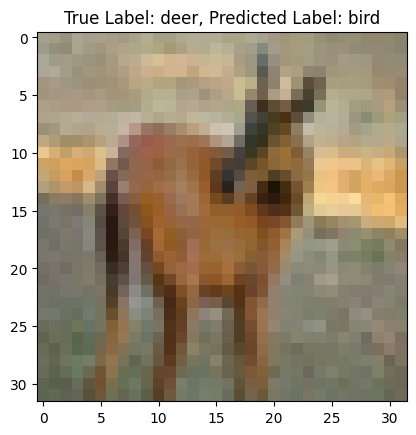

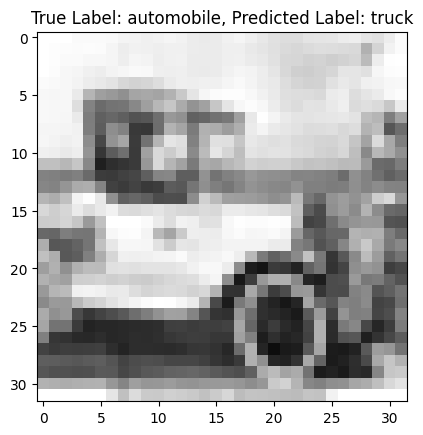

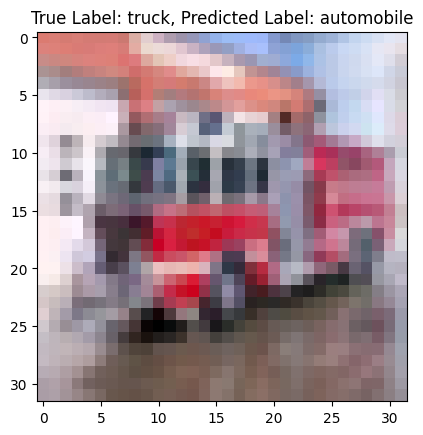

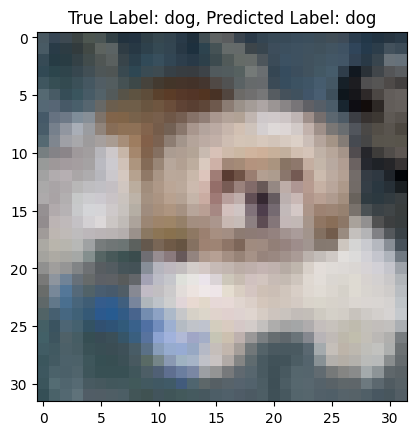

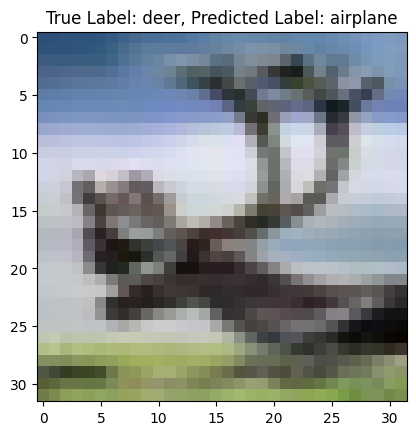

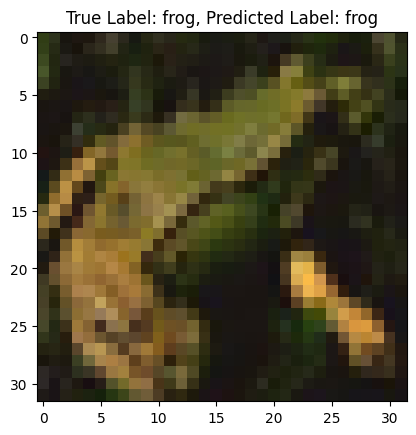

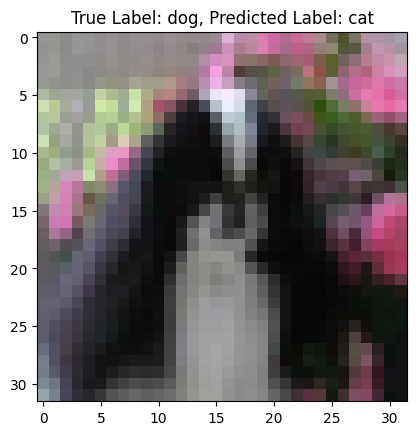

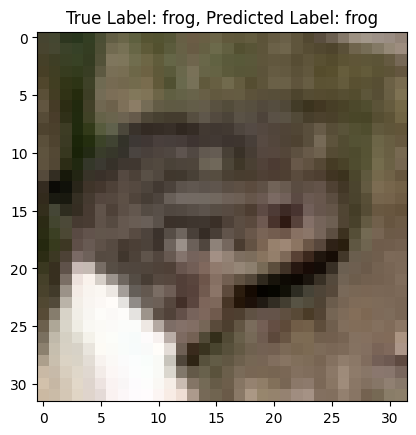

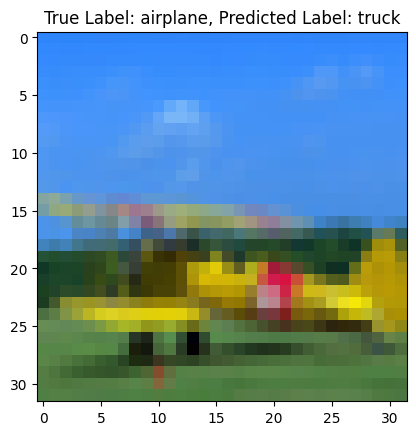

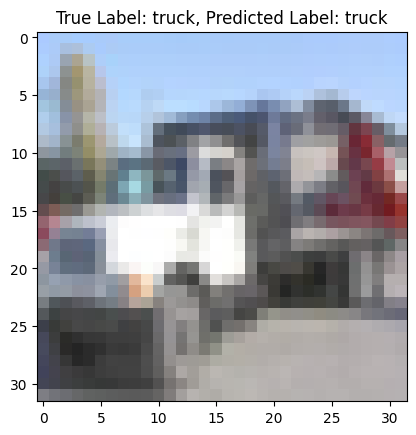

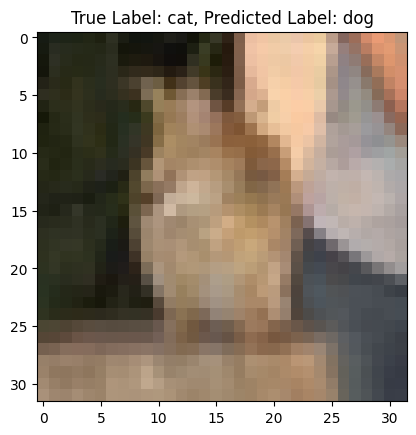

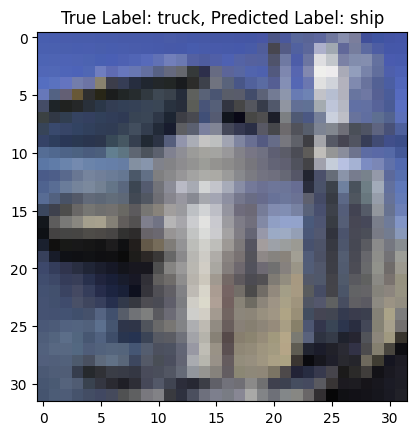

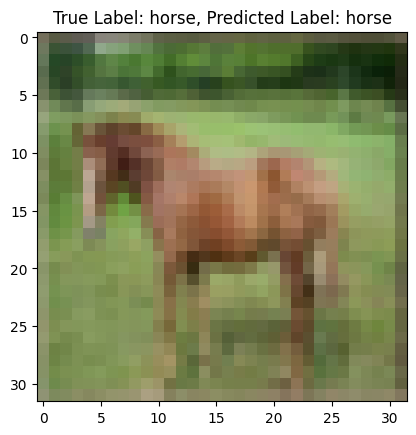

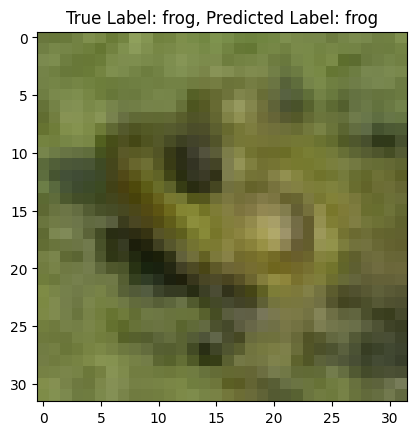

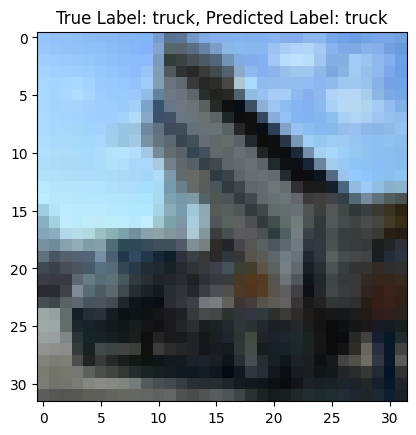

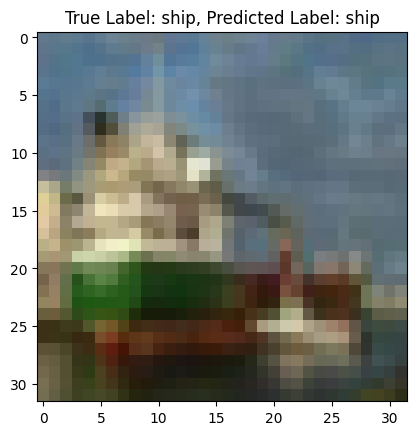

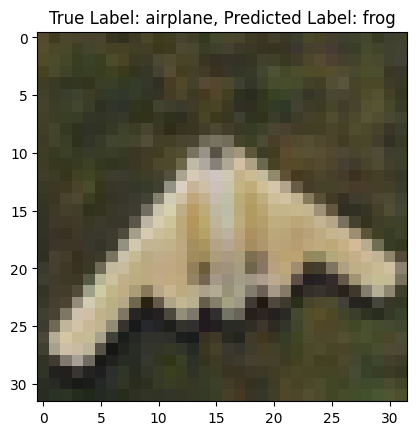

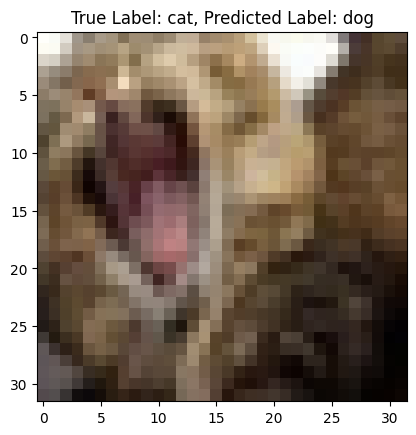

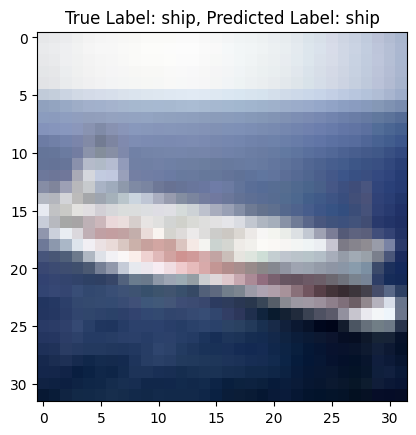

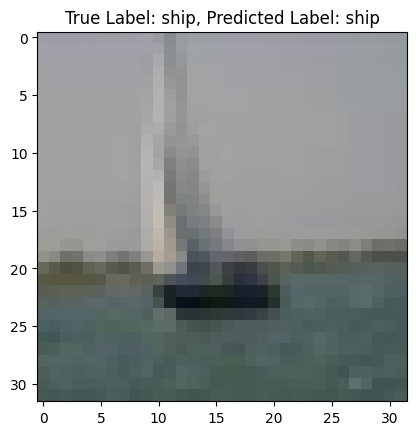

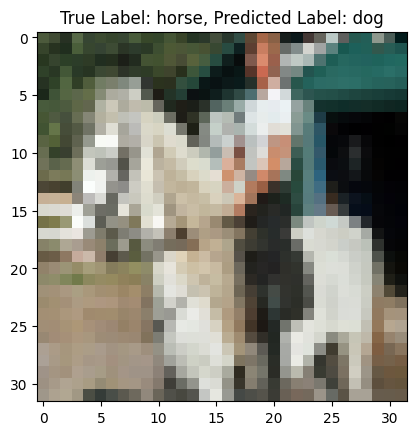

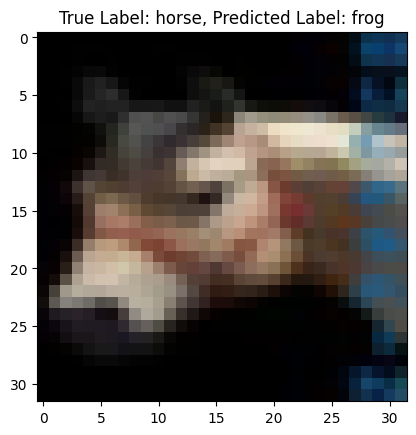

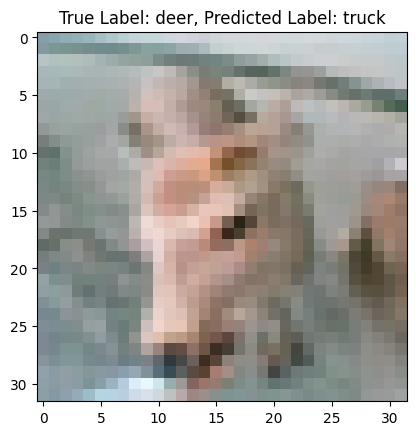

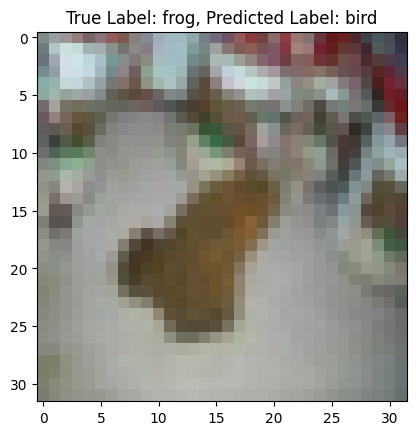

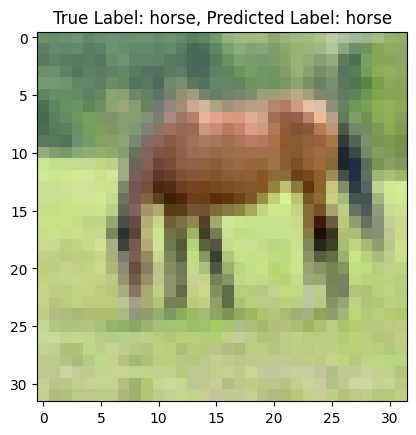

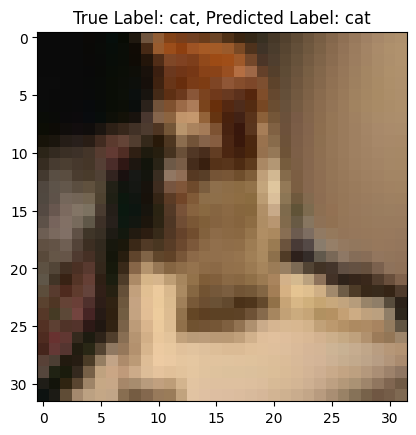

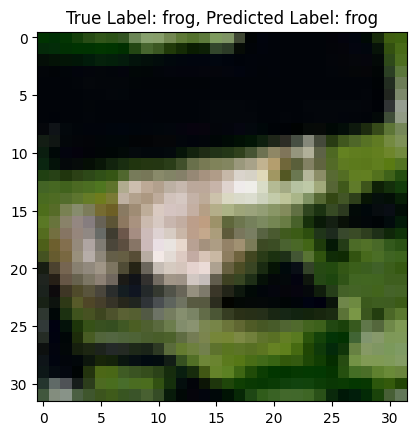

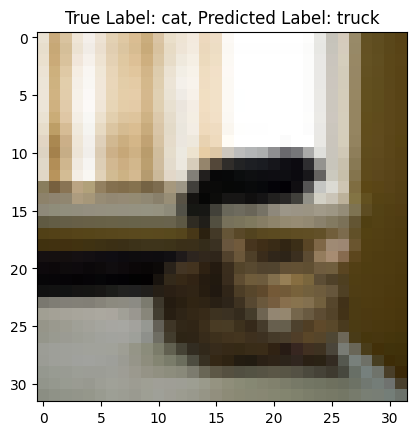

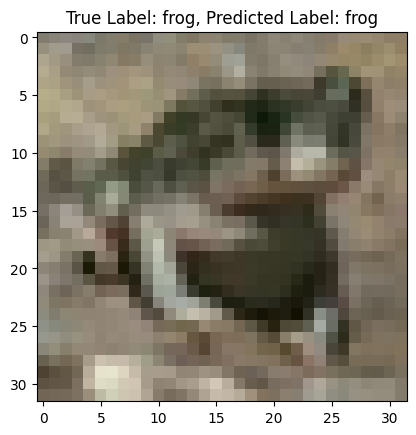

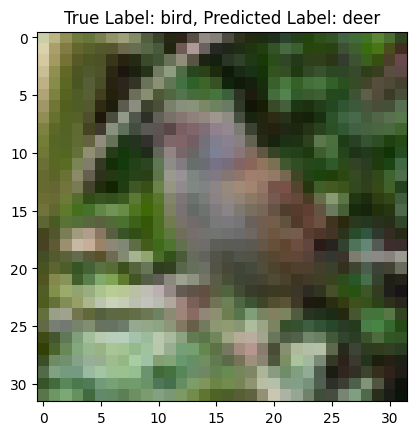

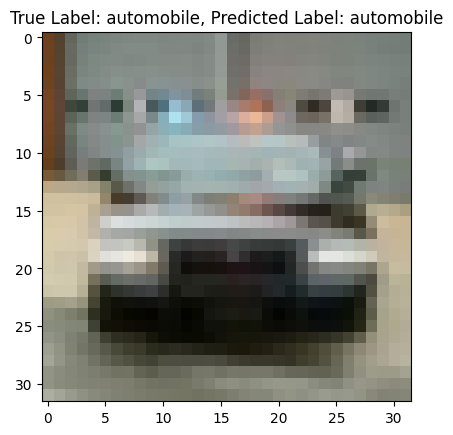

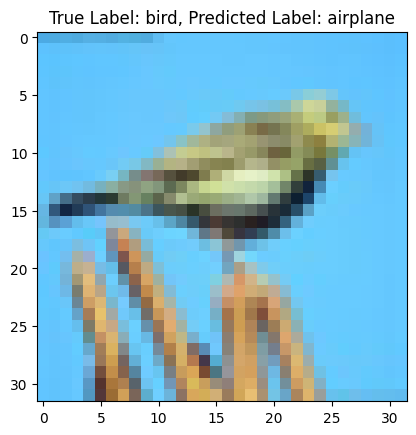

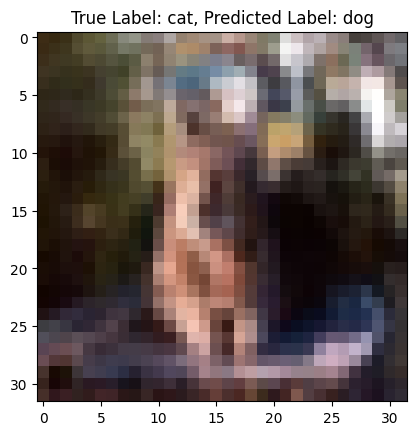

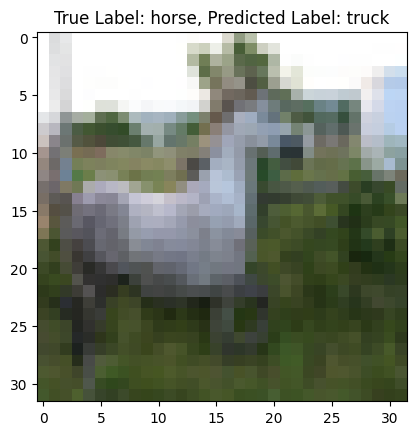

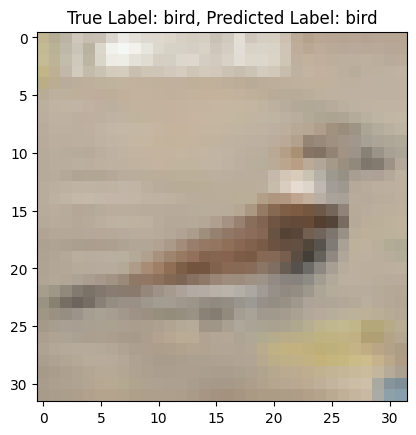

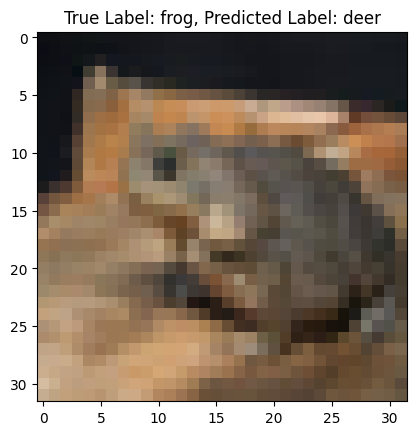

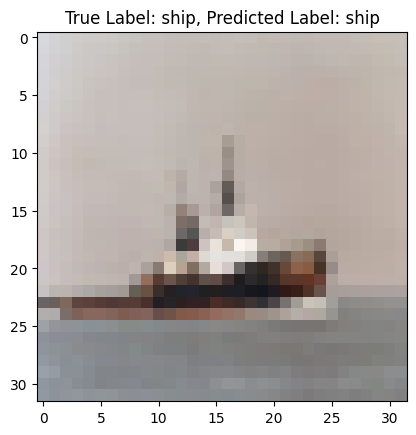

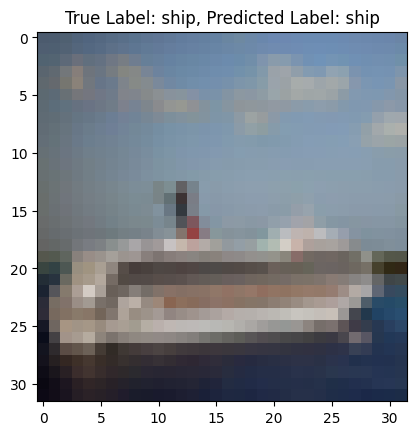

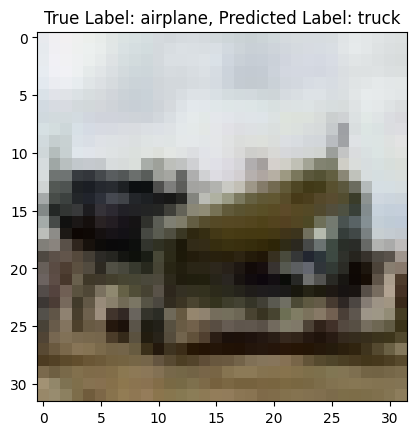

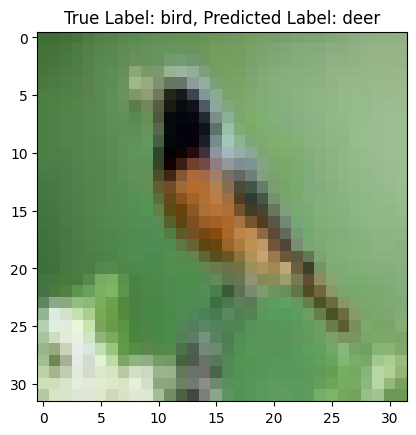

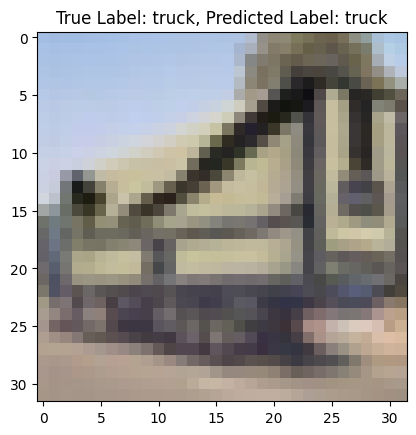

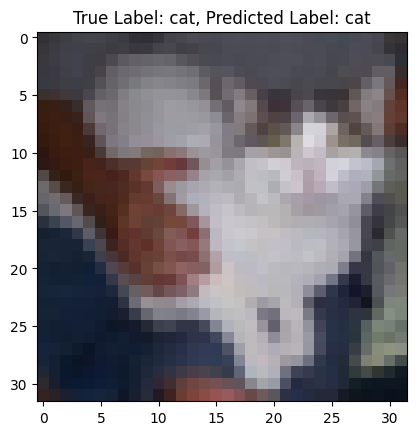

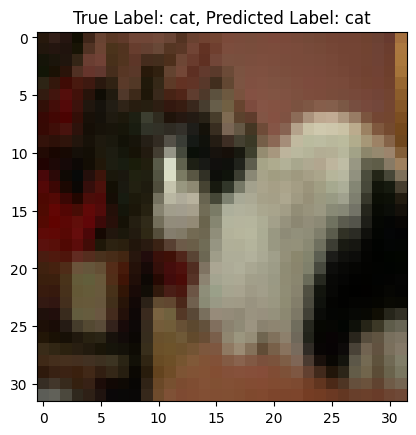

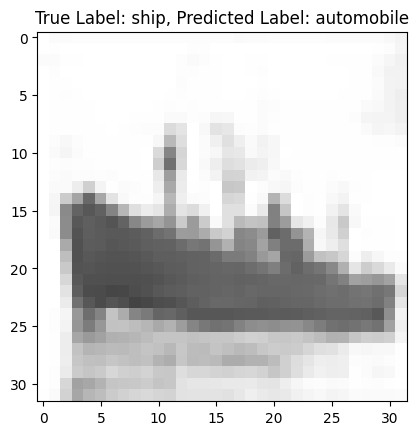

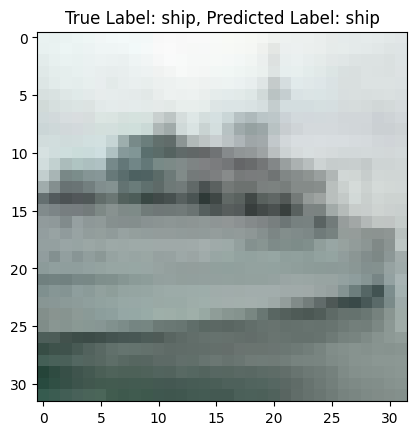

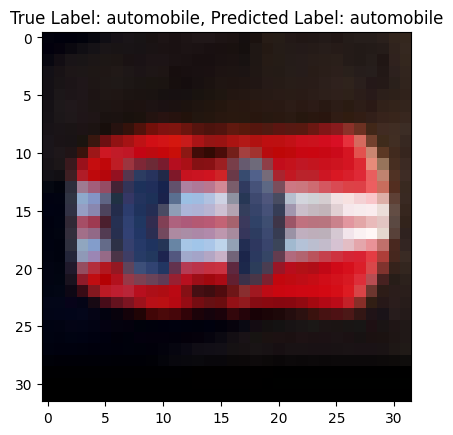

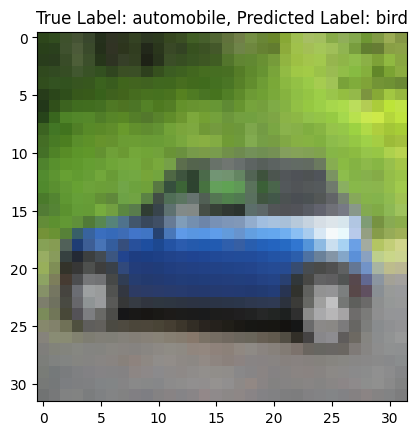

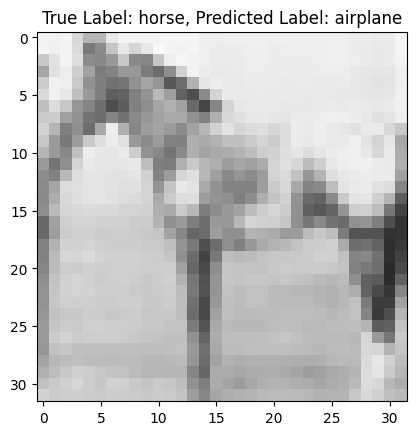

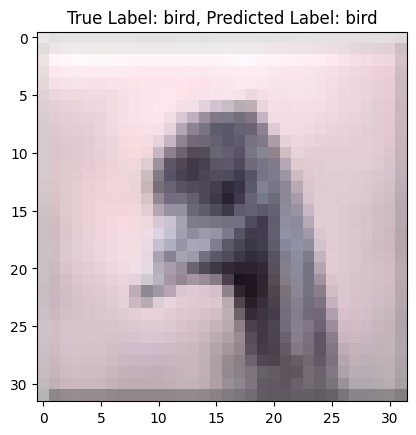

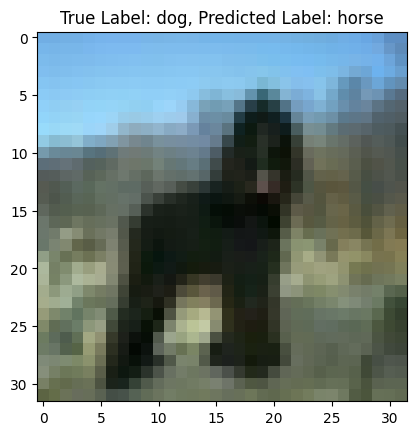

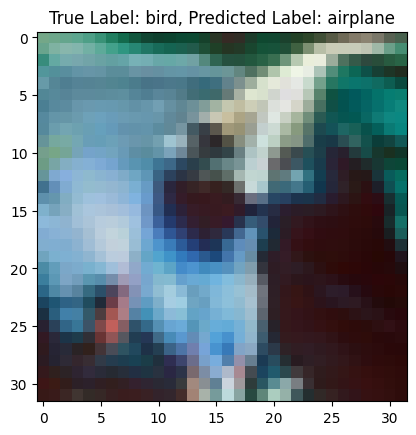

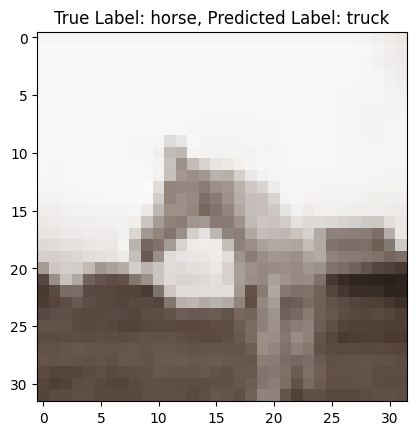

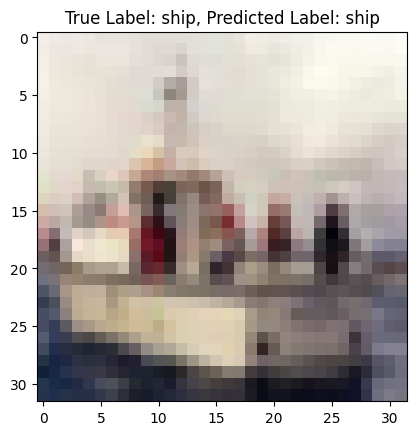

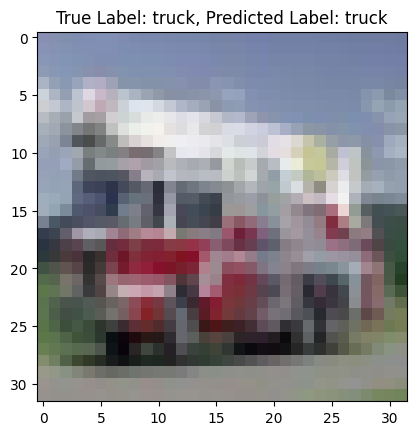

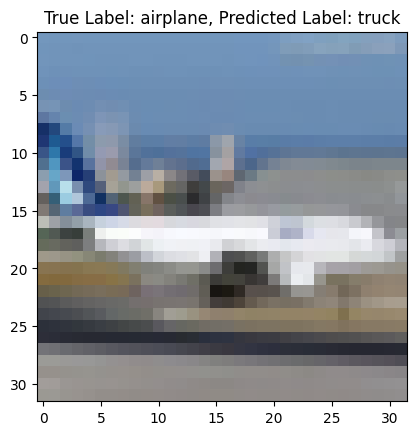

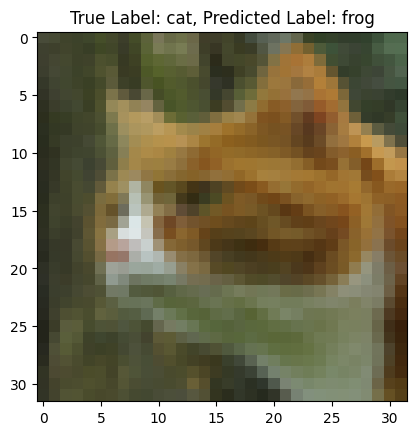

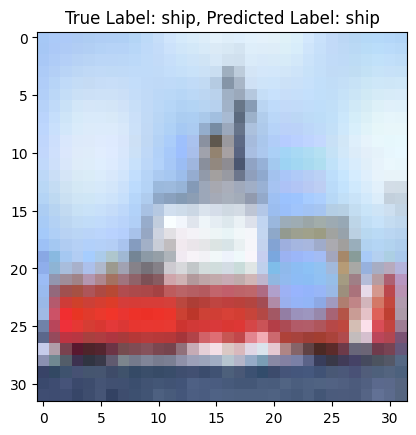

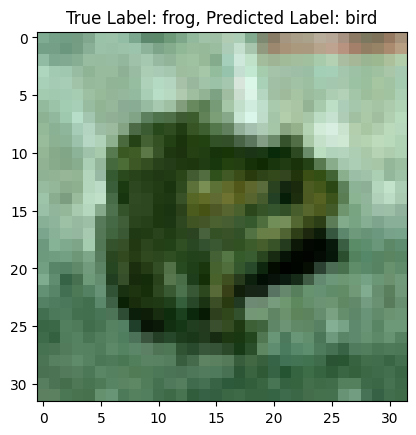

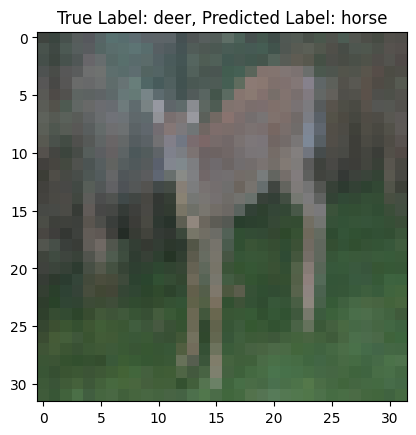

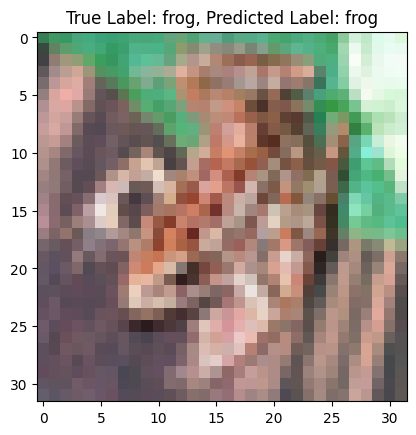

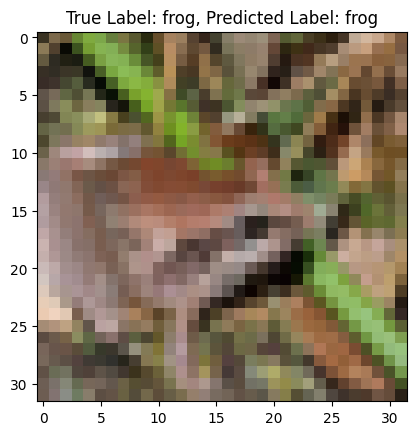

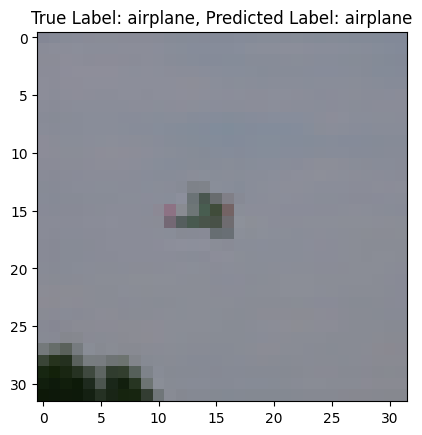

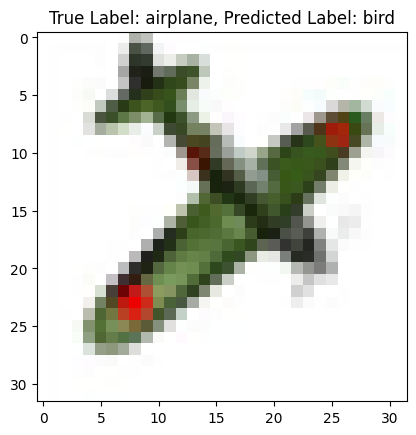

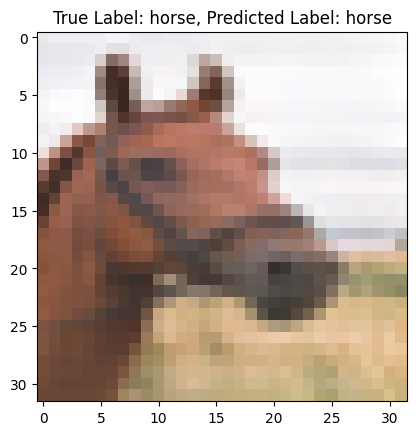

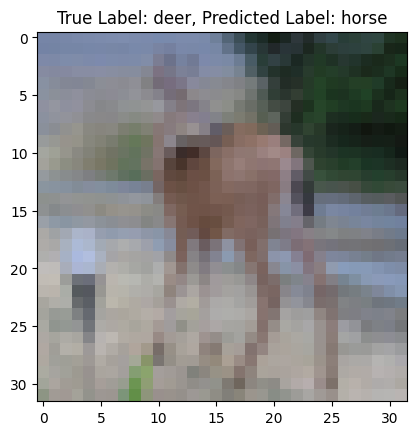

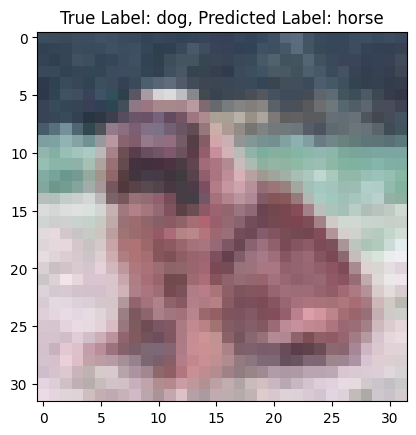

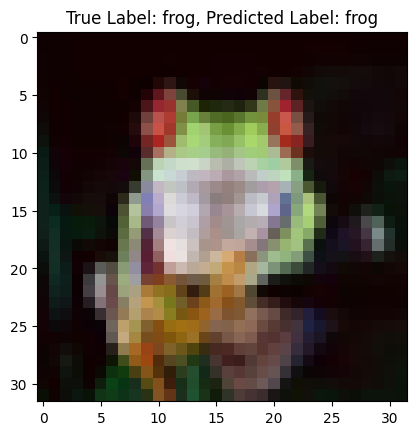

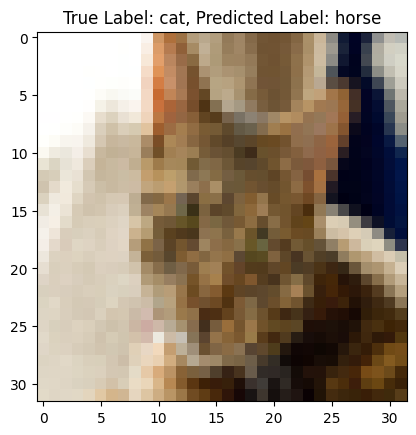

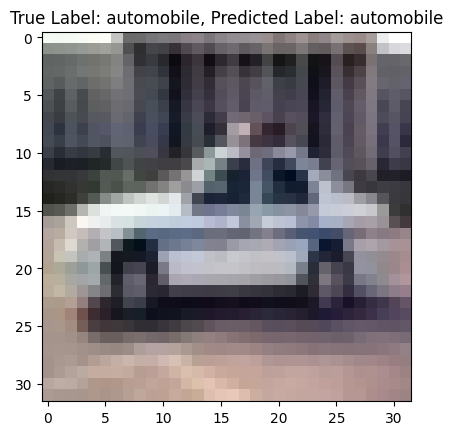

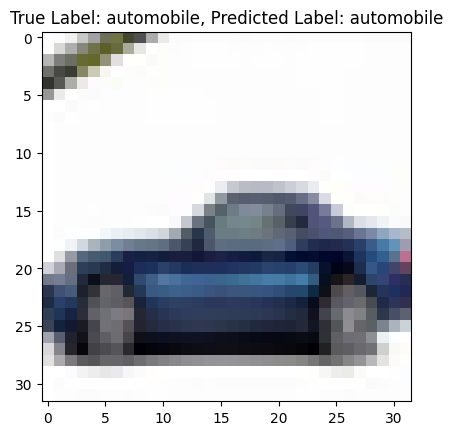

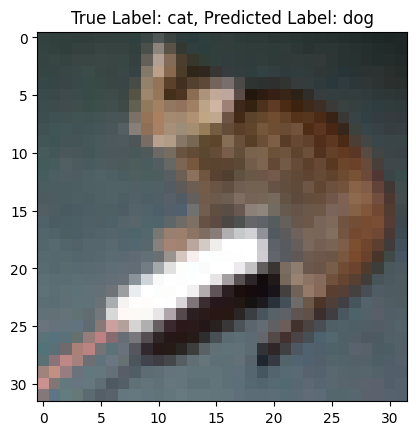

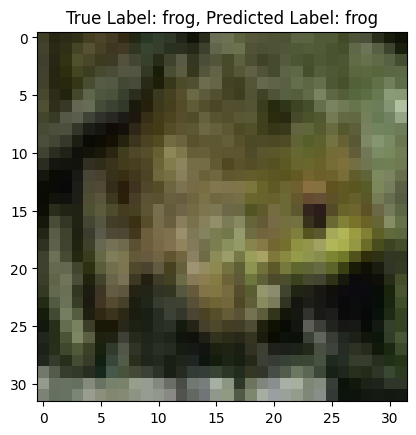

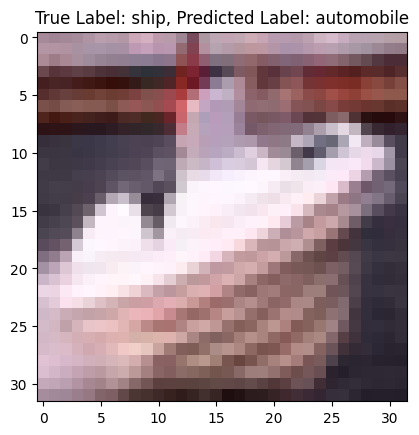

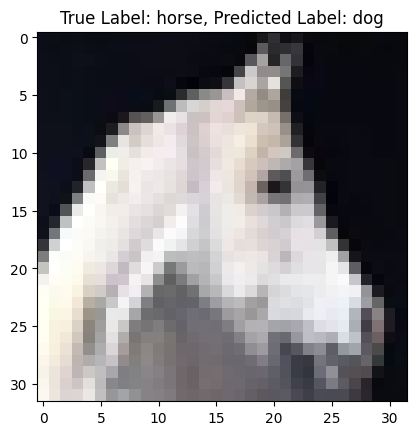

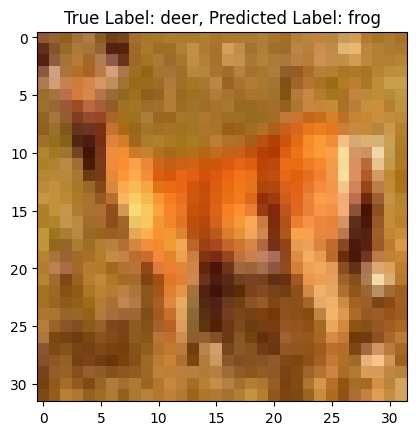

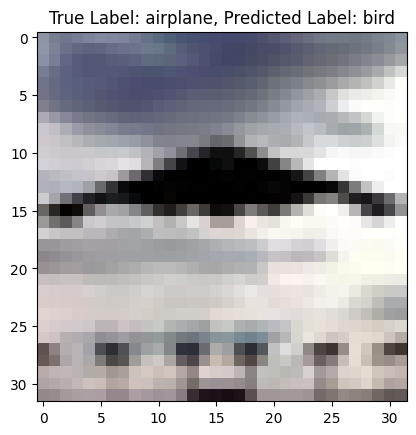

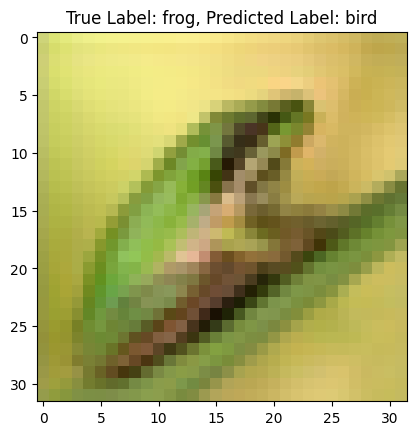

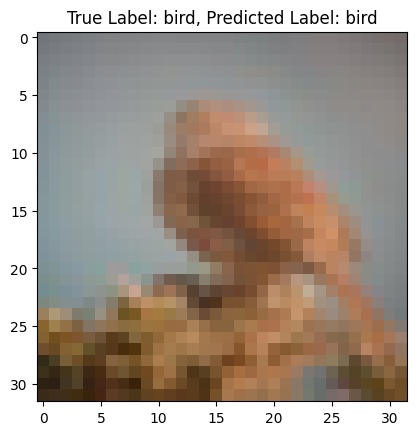

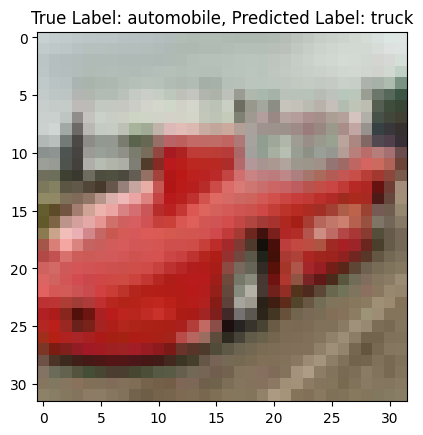

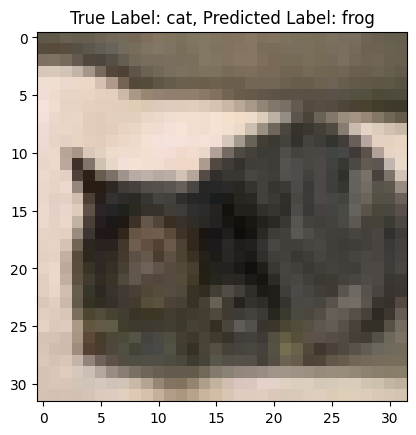

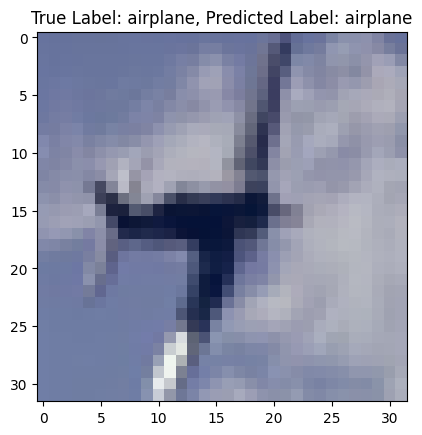

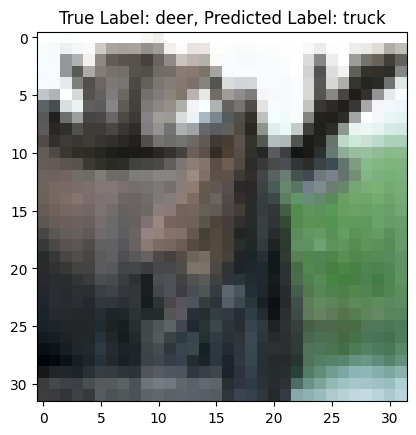

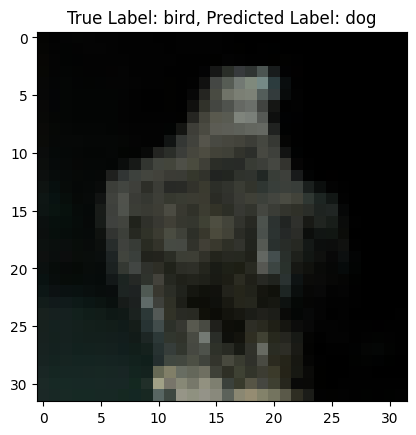

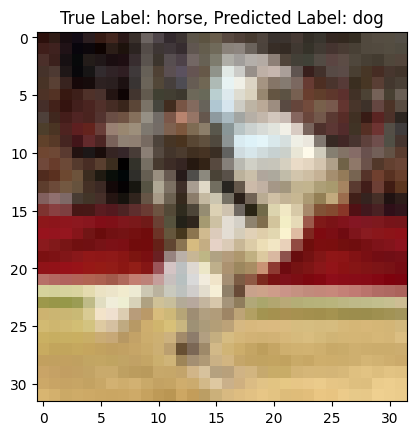

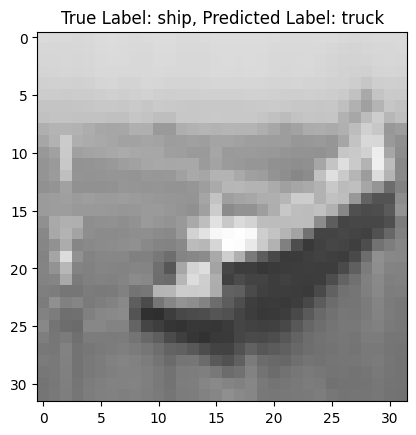

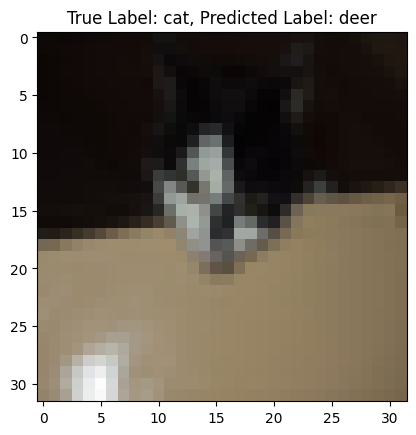

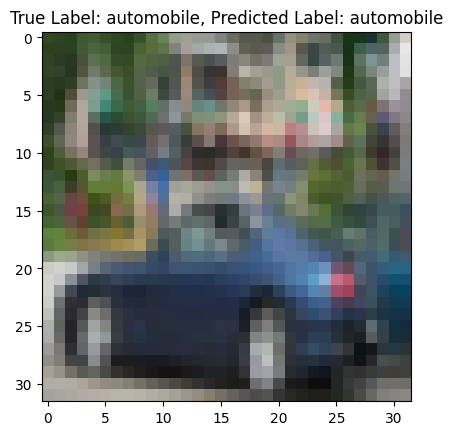

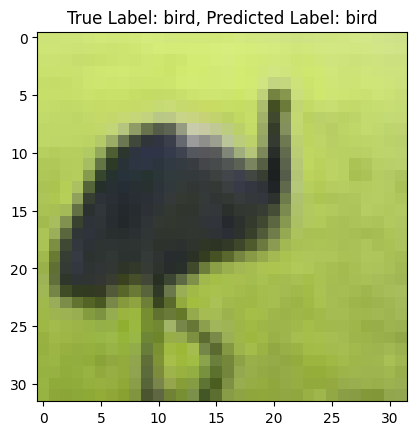

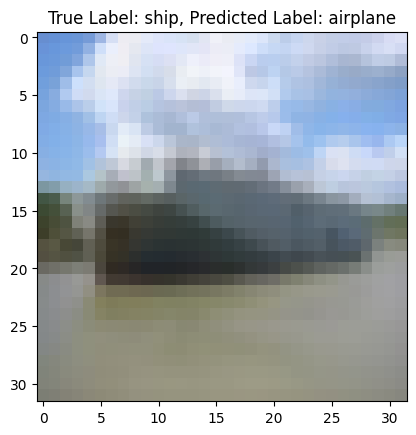

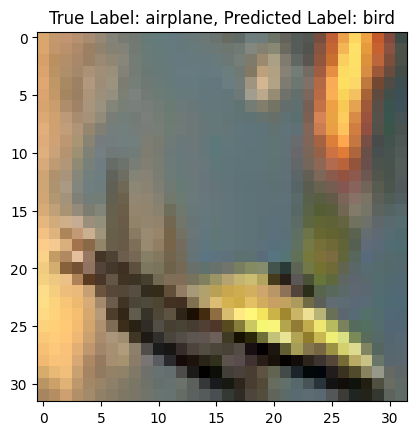

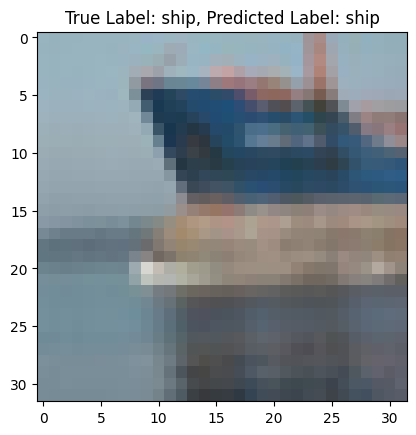

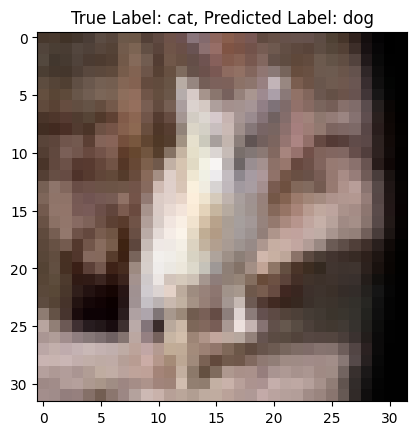

In [ ]:
im_names = []
labels = []
ind = 0

net1.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i > 1:
            break
        for j in range(batch[0].shape[0]):
            images = batch[0][j, :, :, :]
            labels.append(batch[1][j].item())

            images = images.view(-1, 32 * 32 * 3).to(device) # Flatten the images

            logits = net1(images)
            predicted_labels = logits.argmax(dim=1)

            im_name = f"{ind}.jpg"
            im_names.append(im_name)
            save_image(images.view(-1, 3, 32, 32).squeeze(), f"images/{im_name}", normalize=True)

            plt.figure()
            plt.imshow(images.view(-1, 3, 32, 32).squeeze().cpu().numpy().transpose(1, 2, 0))
            plt.title(f"True: {class_names[labels[ind]]}, Predicted: {class_names[predicted_labels.item()]}")
            plt.show()

            ind += 1

Conclusion for NN:

Seems the prediction is highly affected by the color of the pictures, might need Data Augmentation to give it more data.

In [ ]:
net2.eval()
acc = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch[0].to(device), batch[1].to(device)
        logits = net2(images)
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        acc += (predicted == labels).sum().item()

acc_cnn = 100.0 * acc / total

print("CNN Accuracy: {:.2f}%".format(acc_cnn))

CNN Accuracy: 77.33%


In [ ]:
im_names = []
labels = []
ind = 0

net2.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i > 1:
            break
        for j in range(batch[0].shape[0]):
            images = batch[0][j, :, :, :]
            labels.append(batch[1][j].item())

            images = images.unsqueeze(0).to(device) #Add dimension

            logits = net2(images)
            predicted_labels = logits.argmax(dim=1)

            im_name = f"{ind}.jpg"
            im_names.append(im_name)
            save_image(images.squeeze(), f"images/{im_name}", normalize=True)

            plt.figure()
            plt.imshow(images.squeeze().cpu().numpy().transpose(1, 2, 0))
            plt.title(f"True: {class_names[labels[ind]]}, Predicted: {class_names[predicted_labels.item()]}")
            plt.show()

            ind += 1


###Q5: Fine-tune ResNet18 model trained on ImageNet for CIFAR10 dataset.

layer conv1.weight has requires_grad True
layer bn1.weight has requires_grad True
layer bn1.bias has requires_grad True
layer layer1.0.conv1.weight has requires_grad True
layer layer1.0.bn1.weight has requires_grad True
layer layer1.0.bn1.bias has requires_grad True
layer layer1.0.conv2.weight has requires_grad True
layer layer1.0.bn2.weight has requires_grad True
layer layer1.0.bn2.bias has requires_grad True
layer layer1.1.conv1.weight has requires_grad True
layer layer1.1.bn1.weight has requires_grad True
layer layer1.1.bn1.bias has requires_grad True
layer layer1.1.conv2.weight has requires_grad True
layer layer1.1.bn2.weight has requires_grad True
layer layer1.1.bn2.bias has requires_grad True
layer layer2.0.conv1.weight has requires_grad True
layer layer2.0.bn1.weight has requires_grad True
layer layer2.0.bn1.bias has requires_grad True
layer layer2.0.conv2.weight has requires_grad True
layer layer2.0.bn2.weight has requires_grad True
layer layer2.0.bn2.bias has requires_grad Tru

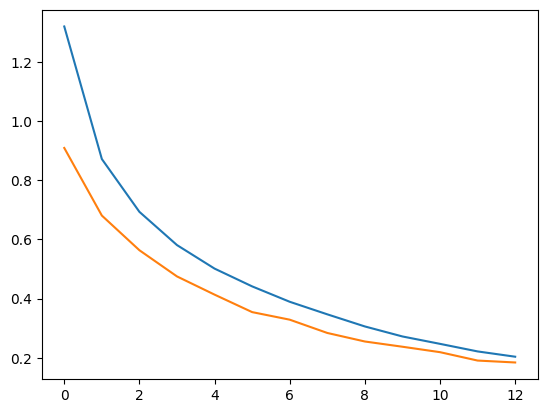

In [ ]:
#Fine=tuning just the first and last layer

device=torch.device('cuda:0')

net=models.resnet18(pretrained=True).to(device)
for name,layer in net.named_parameters():
  layer.requires_grad=True
#  if 'layer3' in name or 'layer4' in name or 'fc' in name or 'layer2' in name:
#    layer.requires_grad = True

net.conv1=nn.Conv2d(3, 64, kernel_size=3, stride=1, padding = 1, bias=False).to(device)
net.fc=nn.Linear (in_features=512, out_features=10, bias=True).to(device)


for name,layer in net.named_parameters():
  print(f"layer {name} has requires_grad {layer.requires_grad}")

lr=0.0001
optimizer = optim.Adam(net.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)

ls=[]
ls_val=[]

for i in range(13):
  loss_train=0
  acc_train=0
  total_train=0

  for ii,batch in enumerate(train_loader):
    data=batch[0]
    label=batch[1]
    #optimizer-->buffer += grad
    optimizer.zero_grad()
    data, label = data.to(device), label.to(device)
    logits = net(data)
    #this is the output of the network and it's shape is batch_size X no of classes
    loss = F.cross_entropy(logits, label)
    loss_train+=loss.item()

    loss.backward()
    optimizer.step()
    out=torch.argmax(logits, dim=1)
    acc_train+=torch.sum(out==label)
    total_train+=logits.shape[0]

  loss_val=0
  acc_val=0
  total_val=0
  with torch.no_grad():
    for jj,batch in enumerate(valid_loader):
          data=batch[0]
          label=batch[1]
          #optimizer-->buffer += grad
          data, label = data.to(device), label.to(device)
          logits = net(data)
          loss = F.cross_entropy(logits, label)
          loss_val+=loss.item()
          out=torch.argmax(logits, dim=1)
          acc_val+=torch.sum(out==label)
          total_val+=logits.shape[0]

  ls.append(loss_train / len(train_loader))
  ls_val.append(loss_val/ len(valid_loader))

  lr_scheduler.step()
  print(f"Iterataion {i}: Training Loss: {loss_total/ii}, Validation Loss: {loss_val/jj}")
  print(f"Iteataion {i}: Training Accuracy: {acc_train.item()/total_train}, Validation Accuracy  {acc_val.item()/total_val}")

plt.plot(ls, label='Training Loss')
plt.plot(ls_val, label='Valiadation Loss')

###Q6:Compare the accuarcay of simple CNN and ResNet18 model on the test set

In [ ]:
net.eval()
acc = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch[0].to(device), batch[1].to(device)
        logits = net(images)
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        acc += (predicted == labels).sum().item()

acc_resnet = 100.0 * acc / total

print("Simple CNN Accuracy: {:.2f}%".format(acc_cnn))
print("ResNet18 Accuracy: {:.2f}%".format(acc_resnet))

Simple CNN Accuracy: 77.33%
ResNet18 Accuracy: 86.42%


In [ ]:
im_names = []
labels = []
ind = 0

net.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i > 1:
            break
        for j in range(batch[0].shape[0]):
            images = batch[0][j, :, :, :]
            labels.append(batch[1][j].item())

            images = images.unsqueeze(0).to(device) #Add dimension

            logits = net2(images)
            predicted_labels = logits.argmax(dim=1)

            im_name = f"{ind}.jpg"
            im_names.append(im_name)
            save_image(images.squeeze(), f"images/{im_name}", normalize=True)

            plt.figure()
            plt.imshow(images.squeeze().cpu().numpy().transpose(1, 2, 0))
            plt.title(f"True: {class_names[labels[ind]]}, Predicted: {class_names[predicted_labels.item()]}")
            plt.show()

            ind += 1